In [16]:
import os
#import pandas as pd
import numpy as np
import cv2
#from PIL import Image
import random
#import tensorflow as tf
#import re
#import datetime
#import io
#from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
#import pickle
from sklearn.model_selection import train_test_split
from nltk.metrics.distance import edit_distance
#import string
#from utils import generate_token_index
#from utils import score_prediction, generate_token_index, y_labels, generate_dataset
import json

%matplotlib inline

In [28]:
data_folder = '../datasets/'

In [29]:
with open(data_folder + 'gt.json') as f:
    dataset = json.load(f)
    
#with open(params.ground_truth_json) as f:
#    dataset_file = json.load(f)

In [33]:
len(dataset['train'])

93409

In [2]:
data_folder = '../datasets/'

In [3]:
maxTextLen = 30

dataset_orig = []

f=open(data_folder + 'words.txt')
chars = set()
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    # filename: part1-part2-part3 --> part1/part1-part2/part1-part2-part3.png
    fileNameSplit = lineSplit[0].split('-')
    fileName = data_folder + 'words/' + fileNameSplit[0] + '/' + fileNameSplit[0] + '-' + fileNameSplit[1] + '/' + lineSplit[0] + '.png'

    # GT text are columns starting at 9
    gtText = ' '.join(lineSplit[8:])[:maxTextLen]
    chars = chars.union(set(list(gtText)))

    # put sample into list
    dataset_orig.append((gtText, fileName))

In [4]:
dataset_orig[0]

('A', '../datasets/words/a01/a01-000u/a01-000u-00-00.png')

In [5]:
#select only a fraction
fraction = 0.01
max_len = int(len(dataset_orig) * fraction)

In [6]:
indices = np.random.randint(0, len(dataset_orig), max_len)
dataset = [dataset_orig[j] for j in indices]
#len(dataset)
#dataset = dataset_orig
print(len(dataset))

1153


In [7]:
dataset[0]

(',', '../datasets/words/g03/g03-043/g03-043-10-05.png')

In [8]:
dim = 128

y_size = dim
x_size = dim * 3

In [9]:
def preprocessing(dataset, y_size, x_size):
    imgs = []
    words = []

    for ind in range(len(dataset)):

    #for ind in range(30):
    #    print(ind)
        fpath = dataset[ind][1]
        #print(file)
        img = cv2.imread(fpath, 0)
        if img is not None:            
            (wt, ht) = x_size, y_size
            (h, w) = img.shape
            fx = w / wt
            fy = h / ht
            f = max(fx, fy)
            newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
            img = cv2.resize(img, newSize)
            target = np.ones([ht, wt]) * 255
            target[0:newSize[1], 0:newSize[0]] = img

            # transpose for TF
            #img = cv2.transpose(target)

            img = target
            
            # normalize
            (m, s) = cv2.meanStdDev(img)
            m = m[0][0]
            s = s[0][0]
            img = img - m
            img = img / s if s>0 else img            
            
            imgs.append(img)
            words.append(dataset[ind][0])

    array_images = np.asarray(imgs)
    
    return array_images, words 

In [10]:
array_images, words = preprocessing(dataset, y_size, x_size)

In [11]:
array_images.shape

(1153, 128, 384)

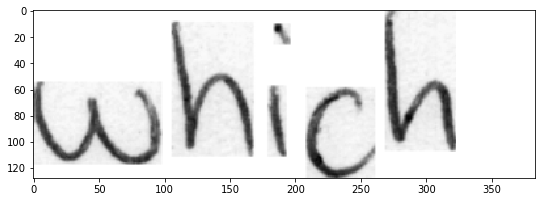

word =  which


In [12]:
index = random.randint(0, array_images.shape[0] - 1)
plt.figure(figsize=(9, 9)) 
#plt.imshow(np.reshape(array_images[index, :, :], (y_size, x_size)), cmap=plt.get_cmap('gray'))
plt.imshow(array_images[index, :, :], cmap=plt.get_cmap('gray'))
plt.show()
print("word = ", words[index])

In [13]:
#target_texts = []
max_decoder_seq_length = 0.
decoder_tokens = set()

for word in words:
#    word = '[' + word + ']'
    decoder_tokens.add('[')
    decoder_tokens.add(']')

    if len(word) > max_decoder_seq_length:
        max_decoder_seq_length = len(word)
    for letter in word:
        decoder_tokens.add(letter)
    #    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    
#    input_texts.append(input_text)
#    target_texts.append(word

max_decoder_seq_length += 2    
decoder_tokens  = list(decoder_tokens)

In [23]:
max_decoder_seq_length

19

In [24]:
def generate_token_index(decoder_tokens):
    #decoder_tokens += ':[]'
    num_decoder_tokens = len(decoder_tokens)
    
    return dict((k, v) for v, k in enumerate(decoder_tokens)), num_decoder_tokens

In [25]:
target_token_index, num_decoder_tokens = generate_token_index(decoder_tokens)
#max_decoder_seq_length = 5

In [26]:
num_decoder_tokens

71

### tran test split 

In [27]:
#array_images = np.reshape(array_images, (-1, y_size, x_size, 1))
array_images = np.reshape(array_images, (-1, y_size, x_size, 1))

In [28]:
random_state = 46
test_size=0.1
val_size = 0.1
array_images_train_val, array_images_test, words_train_val, words_test = train_test_split(array_images, words, test_size=test_size, random_state=random_state)  
array_images_train, array_images_val, words_train, words_val = train_test_split(array_images_train_val, words_train_val, test_size=val_size, random_state=random_state)  

In [29]:
array_images_train.shape

(933, 128, 384, 1)

In [30]:
len(words_train)

933

In [31]:
def y_labels(ys, max_decoder_seq_length, num_decoder_tokens, target_token_index):

    decoder_input_data = np.zeros( (len(ys),  max_decoder_seq_length, num_decoder_tokens), dtype='float32')
    decoder_target_data = np.zeros( (len(ys), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
    
    for i, target_text in enumerate(ys):
        target_text = '[' + target_text + ']'
        
        for t, char in enumerate(target_text):
            decoder_input_data[i, t, target_token_index[char]] = 1.
            if t > 0:
                decoder_target_data[i, t - 1, target_token_index[char]] = 1.

    return decoder_input_data, decoder_target_data

In [32]:
#create one-hot labelling for target sequence
decoder_input_data_train, decoder_target_data_train = y_labels(words_train, max_decoder_seq_length, num_decoder_tokens, target_token_index)
decoder_input_data_val, decoder_target_data_val = y_labels(words_val, max_decoder_seq_length, num_decoder_tokens, target_token_index)
decoder_input_data_test, decoder_target_data_test = y_labels(words_test, max_decoder_seq_length, num_decoder_tokens, target_token_index)

In [33]:
decoder_target_data_train.shape

(933, 19, 71)

### Data augmentation

In [34]:
#from keras.preprocessing.image import ImageDataGenerator
# define data preparation
#train_datagen = ImageDataGenerator(
#                             #featurewise_center=True, featurewise_std_normalization=True, 
#                             #samplewise_center=True, samplewise_std_normalization=True,
##                             rescale=1./255,
#                             #rotation_range=5, width_shift_range=0.05, height_shift_range=0.1, 
#                             #shear_range = 3, zoom_range = [0.9, 1.1], 
#                             rotation_range=5, width_shift_range=0.1, height_shift_range=0.2, 
#                             shear_range = 5, zoom_range = [0.8, 1.2], 
#                             horizontal_flip=False, data_format='channels_last')

#val_datagen = ImageDataGenerator(
#                                 #rescale=1./255, 
#                                 #samplewise_center=True, samplewise_std_normalization=True,
#                                 data_format='channels_last')

### Keras model

In [35]:
#from __future__ import print_function
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Conv2D, MaxPooling2D, Reshape, Dropout, BatchNormalization, Activation, Bidirectional, concatenate, add, Lambda, Permute
from keras.callbacks import EarlyStopping
#import keras.backend as K
from keras.optimizers import Adam

Using TensorFlow backend.


In [36]:
latent_dim = 512  # Latent dimensionality of the encoding space.
#optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [37]:
## Define an input sequence and process it.
encoder_inputs = Input(shape=(y_size, x_size, 1), name='input_encoder')

#encoder_inputs = Input(shape=(92, 248, 1), name='input_encoder')

#(7,7)
encoder_layer = Conv2D(16, (7, 7), padding='same', use_bias=False, name='conv_1')(encoder_inputs)
encoder_layer = BatchNormalization(name='batch_norm_1')(encoder_layer)
encoder_layer = Activation('relu', name='activation_1')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(2, 2), padding='valid', name='maxpool_1')(encoder_layer)

#(7,7)
encoder_layer = Conv2D(32, (5, 5), padding='same', use_bias=False, name='conv_2')(encoder_layer)
encoder_layer = BatchNormalization(name='batch_norm_2')(encoder_layer)
encoder_layer = Activation('relu', name='activation_2')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(2, 2), padding='valid', name='maxpool_2')(encoder_layer)

#(5,5)
encoder_layer = Conv2D(64, (5, 5), padding='same', use_bias=False, name='conv_3')(encoder_layer)
encoder_layer = BatchNormalization(name='batch_norm_3')(encoder_layer)
encoder_layer = Activation('relu', name='activation_3')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(2, 2), padding='valid', name='maxpool_3')(encoder_layer)

#(5,5)
encoder_layer = Conv2D(128, (3, 3), padding='same', use_bias=False, name='conv_4')(encoder_layer)
encoder_layer = BatchNormalization(name='batch_norm_4')(encoder_layer)
encoder_layer = Activation('relu', name='activation_4')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(2, 2), padding='valid', name='maxpool_4')(encoder_layer)

#(3,3)
encoder_layer = Conv2D(256, (3, 3), padding='same', use_bias=False, name='conv_5')(encoder_layer)
encoder_layer = BatchNormalization(name='batch_norm_5')(encoder_layer)
encoder_layer = Activation('relu', name='activation_5')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(2, 2), padding='valid', name='maxpool_5')(encoder_layer)

#(3,3)
encoder_layer = Conv2D(512, (3, 3), padding='same', use_bias=False, name='conv_6')(encoder_layer)
encoder_layer = BatchNormalization(name='batch_norm_6')(encoder_layer)
encoder_layer = Activation('relu', name='activation_6')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(2, 2), padding='valid', name='maxpool_6')(encoder_layer)


#(2,2)
#encoder_layer = Conv2D(512, (3, 3), padding='same', use_bias=False, name='conv_6')(encoder_layer)
#encoder_layer = BatchNormalization(name='batch_norm_6')(encoder_layer)
#encoder_layer = Activation('relu', name='activation_6')(encoder_layer)
#encoder_layer = MaxPooling2D(pool_size=(2, 2), padding='valid', name='maxpool_6')(encoder_layer)


#(3,3)
#encoder_layer = Conv2D(512, (3, 3), padding='same', use_bias=False, name='conv_6')(encoder_layer)
#encoder_layer = BatchNormalization(name='batch_norm_6')(encoder_layer)
#encoder_layer = Activation('relu', name='activation_6')(encoder_layer)
#encoder_layer = MaxPooling2D(pool_size=(2, 2), padding='valid', name='maxpool_6')(encoder_layer)

conv_shapes = encoder_layer.shape[1:]
timesteps = int(conv_shapes[0]*conv_shapes[1])
num_features = int(conv_shapes[2])

encoder_layer = Reshape((-1, num_features), name='reshape')(encoder_layer)

#encoder
encoder = LSTM(latent_dim, return_state=True, name='lstm_encoder')
_, state_h, state_c = encoder(encoder_layer)
encoder_states = [state_h, state_c]

#decoder
decoder_inputs = Input(shape=(max_decoder_seq_length, num_decoder_tokens), name='input_decoder_teacher_forcing')
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='lstm_decoder')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense_time_dist = TimeDistributed(Dense(num_decoder_tokens, activation='softmax'), name='time_distributed_dense')
decoder_outputs = decoder_dense_time_dist(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_encoder (InputLayer)      (None, 128, 384, 1)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 384, 16) 784         input_encoder[0][0]              
__________________________________________________________________________________________________
batch_norm_1 (BatchNormalizatio (None, 128, 384, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 384, 16) 0           batch_norm_1[0][0]               
__________________________________________________________________________________________________
maxpool_1 

In [39]:
train = False

batch_size = 128  # Batch size for training.
epochs = 50 # Number of epochs to train for.

n_times_aug = 1

# Early stopping  
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

if train == True:    
    # Run training
    model.compile(optimizer=optimizer, loss='categorical_crossentropy')

    model.fit([array_images_train, decoder_input_data_train], decoder_target_data_train, batch_size=batch_size,
              epochs=epochs, validation_data = ([array_images_val, decoder_input_data_val], decoder_target_data_val),
              verbose=1, callbacks=[])
    
#    model.fit_generator(train_datagen.flow([array_images_train, decoder_input_data_train], decoder_target_data_train, batch_size=batch_size),
#                        steps_per_epoch = n_times_aug * len(array_images_train) / batch_size, epochs=epochs, 
#                        validation_data = val_datagen.flow([array_images_val, decoder_input_data_val], decoder_target_data_val, batch_size=batch_size),
#                        validation_steps =  1, verbose=1, callbacks=[early_stop])

In [53]:
model_json = model.to_json()
with open("../snapshots/graph.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("../snapshots/weights.h5")

/home/giovanni/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_decoder was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_encoder_1/while/Exit_3:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lstm_encoder_1/while/Exit_4:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [51]:
#if train == False:
#model.save('../snapshots/model_IAM.h5')
#model.save_weights("../snapshots/weights.h5")

In [54]:
if train == False:
    from keras.models import load_model, model_from_json
    json_file = open('../snapshots/graph.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("../snapshots/weights.h5")    
#    model = load_model('../snapshots/model_IAM.h5')

In [55]:
#model.save_weights("../snapshots/weights.h5")

In [56]:
# Define inference models 
#encoder
#encoder_inputs_inference = Input(shape=(x_size, y_size, 1), name='input_encoder_inference')
encoder_inference = Model(model.get_input_at(0)[0], model.get_layer("lstm_encoder").output[1:])

#decoder
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_inputs_inference = Input(shape=(1, num_decoder_tokens), name='input_decoder_inference')

decoder_lstm = model.get_layer("lstm_decoder")
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_inference, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

#dense layer
decoder_dense = model.get_layer('time_distributed_dense').layer
decoder_outputs = decoder_dense(decoder_outputs)

#inference
decoder_inference = Model([decoder_inputs_inference] + decoder_states_inputs, [decoder_outputs] + decoder_states)

ValueError: Dimensions must be equal, but are 71 and 81 for 'lstm_decoder_6/MatMul' (op: 'MatMul') with input shapes: [?,71], [81,512].

In [ ]:
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

def decode_sequence(input_seq, max_decoder_seq_length=5):
    # Encode the input as state vectors.
    states_value = encoder_inference.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['[']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_inference.predict( [target_seq] + states_value )
           
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == ']'): 
            #or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
pred_train = []

for ind in range(len(words_train)):    
    #row_pred = []

    input_seq = np.reshape( array_images_train[ind,:,:], (-1, y_size,  x_size, 1) )
    
    decoded_sentence = decode_sequence(input_seq)
    decoded_sentence = decoded_sentence.replace("]", "")
    
    #row_pred.append(words_train[ind])
    #row_pred.append(decoded_sentence)
    
    pred_train.append(decoded_sentence)
    
    #print('Data', words_test[ind], '-', ind, 'out of', len(words_test))
    print('True sequence:', words_train[ind])
    print('Decoded sequence:', decoded_sentence, '\n')

In [ ]:
pred_test = []

for ind in range(len(words_test)):    
    #row_pred = []

    input_seq = np.reshape( array_images_test[ind,:,:], (-1, y_size,  x_size, 1) )
    
    decoded_sentence = decode_sequence(input_seq)
    decoded_sentence = decoded_sentence.replace("]", "")
    
    #row_pred.append(words_test[ind])
    #row_pred.append(decoded_sentence)
    
    pred_test.append(decoded_sentence)
    
    #print('Data', words_test[ind], '-', ind, 'out of', len(words_test))
    print('True sentence:', words_test[ind])
    print('Decoded sentence:', decoded_sentence, '\n')

In [ ]:
def score_prediction(y_true, y_pred):
    words_identified = 0
    characters_identified = 0
    char_tot = 0
#    CER = 0

#    list_accuracy_characters = []
    
    for i in range(len(y_pred)):
        #pred_row = [y_true[i], y_pred[i]] 
        
        #check if date are the same
        #if pred_row[0] == pred_row[1]:
        if y_true[i] == y_pred[i]:

            words_identified += 1
            
#        if len(pred_row[1]) < len(pred_row[0]):
#            pred_row[1] += '-' * (len(pred_row[0]) - len(pred_row[1]))    
#        elif len(pred_row[1]) > len(pred_row[1]):

#            pred_row[1] = pred_row[1][0:len(pred_row[0])]

        #check the number of characters that are the same
 #       print(y_true[i])
 #       print(y_pred[i])
        
        levenshtein_distance = edit_distance(y_true[i], y_pred[i])
        n_char = np.maximum(len(y_true[i]), len(y_pred[i]))
        
        normalized_distance = levenshtein_distance/n_char

        characters_identified += normalized_distance
#        char_tot += n_char
        
#        CER += normalized_distance
        
#        print(len(y_true[i]))
#        for k in range(len(y_true[i])):
#            print()
#            if y_true[i][k] == y_pred[1][k]:
#        characters_identified += 1
#        char_tot += 1

    # array_accuracy_characters = np.asarray(list_accuracy_characters)
    CER = float((characters_identified) / len(y_true))
    WER = (len(y_pred) - words_identified)/len(y_pred) 
        
    return CER, WER
#    return WER

In [ ]:
CER_test, WER_test = score_prediction(words_test, pred_test)
#WER_test = score_prediction(words_test, pred_test)
print('CER: ', round(CER_test * 100, 3), '%')
print('WER: ', round(WER_test * 100, 3), '%')

In [ ]:
CER_train, WER_train = score_prediction(words_train, pred_train)
#print('CER: ', round(CER_train * 100, 3), '%')
print('CER: ', round(CER_train * 100, 3), '%')
print('WER: ', round(WER_train * 100, 3), '%')